In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap
import gc
from random import shuffle
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/sample_submission.csv
../input/test.csv
../input/train.csv


In [2]:
import xgboost
xgboost.__version__

'1.4.2'

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [5]:
test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [6]:
columns = test.columns[1:]
columns

Index(['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'],
      dtype='object')

In [7]:
target = np.hstack([np.ones(train.shape[0]), np.zeros(test.shape[0])])

In [8]:
train_test = np.vstack([train[columns].values, test[columns].values])

In [9]:
train_test.shape

(9358, 8)

In [10]:
index = list(range(train_test.shape[0]))
shuffle(index)

In [11]:
train_test = train_test[index, :]
target = target[index]

In [12]:
train_test = train_test.astype(np.float)


In [13]:
train, test, y_train, y_test = train_test_split(train_test, target, test_size=0.33, random_state=42)

In [14]:
train = xgboost.DMatrix(train, label=y_train)
val = xgboost.DMatrix(test, label=y_test)

In [89]:
%%time
param = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist', 
    'predictor': 'gpu_predictor'
}
clf = xgboost.train(param, train, 2500)

CPU times: user 2.91 s, sys: 15.9 ms, total: 2.92 s
Wall time: 2.93 s


In [90]:
preds = clf.predict(val)
roc_auc_score(y_test, preds)


0.9898333614817317

This is a rather significant AUC. It indicates that there is a significant shift in many of the variables. Let us look what variables are the most distinct between the train and test sets.

In [57]:
%%time
shap_preds = clf.predict(val, pred_contribs=True) 

CPU times: user 92.6 ms, sys: 8.09 ms, total: 101 ms
Wall time: 99.6 ms


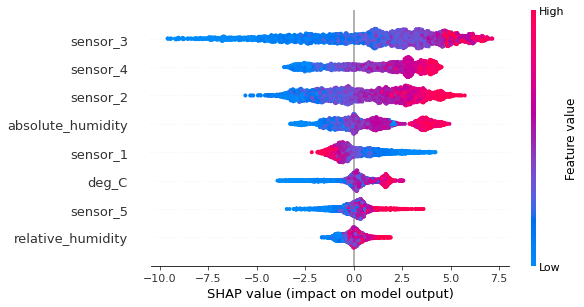

In [58]:
shap.summary_plot(shap_preds[:,:-1], pd.DataFrame(test, columns=columns))

Looks like Sensor 3 data is the most different between the train and test sets. 